In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp,erf
from autograd.scipy.stats import norm
from autograd import grad

#from autograd_gamma import gamma, gammainc, gammaincc, gammaincln, gammainccln

import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

from tree import Tree
from optimizer import Optimizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [15]:
pop_size = 5.0 # exponential parameter for constant pop size prior
data_file = '../dat/DS1/DS1.pickle'

In [16]:
with open(data_file, 'rb') as f:
    DS1 = pickle.load(f)

In [17]:
genomes = []
species = []
for key in DS1:
    genomes.append(DS1[key])
    species.append(key)
    
n_species = len(species)

In [18]:
n_species = 3
genome_size = 100
genomes = ['']*n_species
ps = [[0.9,0.01,0,0,0.09],
      [0.9,0.1,0,0,0.0],
      [0.9,0.1,0,0,0.0]]
for _ in range(genome_size):
    for s in range(n_species):
        genomes[s] += np.random.choice(['A','T','G','C','-'],p=ps[s])
        
#genomes = [["A"],["T"],["C"]]

In [19]:
# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = np.array([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = float)
tree_log_probs = np.log(tree_log_probs)

# Set initial $\theta$ randomly

In [20]:
theta = np.zeros((2,n_species,n_species))

#theta[0] = np.random.normal(size = (n_species,n_species)) + np.log(pop_size)
#theta[0] = theta[0]*np.tril(np.ones((n_species,n_species)),k=-1)
#theta[1] = 0.01*np.random.normal(size = (n_species,n_species))
#theta[1] = theta[1]*np.tril(np.ones((n_species,n_species)),k=-1)

print(theta)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [9]:
Z = np.random.normal(np.ones_like(theta[0]))
log_times = np.exp(theta[1])*Z+theta[0]
log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

tree = Tree(theta,log_times,tree_log_probs,
            pop_size=pop_size)

print(tree.log_like)
print(tree.log_prior)
print(tree.log_q)

-400.63907036363946
-10.493896358093473
-9.66147653508776


# Do Variational Inference

In [10]:
genomes

['AAAAAAAAA-AAAAAAAAAAAAAA-AAAAAAAAAAAAAAAAAAAAAAAA-AAAAAAAAA-AAAAAAAAAA-AAAA--AAAAAAAAA-AAA---AAAAAAA',
 'AAAATAAAAAAAAAAAATAAAAATAAAAAAAAAATATAAAAAAAAAAAAAAAAAAAAAAAATAATAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATAAAT',
 'AATAAATAAAAATAAAAAAAAAAAAAAAATAAAAAAAAAATAAAAAAAATAAAATAAAAAAAAAAAAAAAAAAAAAAAAAAAATTAATAAATAAAAAAAT']

iteration:  0
runtime: 0 mins
grad_norm estimate:  16.88495675023979
ELBO estimate:  -380.8382357034499

iteration:  10
runtime: 0 mins
grad_norm estimate:  27.22653998140372
ELBO estimate:  -317.98883228856346

iteration:  20
runtime: 0 mins
grad_norm estimate:  21.90307011841692
ELBO estimate:  -303.0648634143905

iteration:  30
runtime: 0 mins
grad_norm estimate:  16.82970414052156
ELBO estimate:  -278.6490854938978

iteration:  40
runtime: 0 mins
grad_norm estimate:  21.483716528319867
ELBO estimate:  -257.56819159578356

iteration:  50
runtime: 0 mins
grad_norm estimate:  5.90437913598053
ELBO estimate:  -246.455104279411

iteration:  60
runtime: 0 mins
grad_norm estimate:  6.082344309015346
ELBO estimate:  -243.2488441813011

iteration:  70
runtime: 0 mins
grad_norm estimate:  6.620529424832313
ELBO estimate:  -241.41086758166537

iteration:  80
runtime: 0 mins
grad_norm estimate:  5.399293511411378
ELBO estimate:  -240.11008530915865

iteration:  90
runtime: 0 mins
grad_norm est

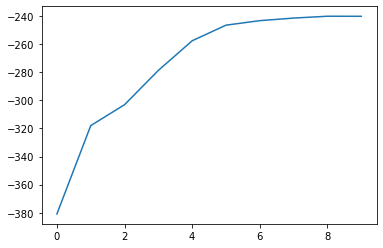

In [11]:
optim_reparam = Optimizer(tree_log_probs,deepcopy(theta))

optim_reparam.optimize_q_reparam(10,100,alphas=[0.1,0.1],pop_size=pop_size)

print("final theta:",optim_reparam.theta)
plt.plot(optim_reparam.ELBO_ests)

[[[ 0.          0.          0.        ]
  [-0.00638129  0.          0.        ]
  [-0.10125846 -0.06494953  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.16348605  0.          0.        ]
  [ 0.21117882 -0.25687052  0.        ]]]
iteration:  0
runtime: 0 mins
grad_norm estimate:  38.43973875516442
ELBO estimate:  -327.4725998018859

[[[ 0.          0.          0.        ]
  [ 0.06333258  0.          0.        ]
  [-0.19118521  0.15653998  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.13711321  0.          0.        ]
  [-0.44975758 -0.20832336  0.        ]]]
[[[ 0.          0.          0.        ]
  [ 0.04770828  0.          0.        ]
  [-0.22425578 -0.1313059   0.        ]]

 [[ 0.          0.          0.        ]
  [-0.00480436  0.          0.        ]
  [ 0.10468453 -0.27051058  0.        ]]]
[[[ 0.          0.          0.        ]
  [ 0.1607867   0.          0.        ]
  [ 0.18476246  0.11123288  0.        ]]

 [[ 0.          0.          0.        ]
 

[[[ 0.          0.          0.        ]
  [-1.18556413  0.          0.        ]
  [-0.24076045 -0.63192619  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.13811475  0.          0.        ]
  [-0.14922601 -0.08057534  0.        ]]]
[[[ 0.          0.          0.        ]
  [ 0.36465274  0.          0.        ]
  [ 0.2100168  -0.5973327   0.        ]]

 [[ 0.          0.          0.        ]
  [-0.60880889  0.          0.        ]
  [-0.1934867  -0.08270185  0.        ]]]
iteration:  40
runtime: 0 mins
grad_norm estimate:  4.6390200992337025
ELBO estimate:  -240.4727614022529

[[[ 0.          0.          0.        ]
  [ 1.05423987  0.          0.        ]
  [ 0.42894075 -0.48568624  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.24860456  0.          0.        ]
  [-0.31475413 -0.36639404  0.        ]]]
[[[ 0.          0.          0.        ]
  [ 0.73779915  0.          0.        ]
  [ 0.02546809  0.14763467  0.        ]]

 [[ 0.          0.          0.        ]

[[[ 0.          0.          0.        ]
  [ 0.09085999  0.          0.        ]
  [ 0.20696978  2.43973134  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.28811529  0.          0.        ]
  [ 0.03748865 -0.35001919  0.        ]]]
[[[ 0.          0.          0.        ]
  [-0.72721573  0.          0.        ]
  [ 0.80224588  2.92015392  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.00933978  0.          0.        ]
  [-0.23908146  0.07104488  0.        ]]]
[[[ 0.          0.          0.        ]
  [-0.67511633  0.          0.        ]
  [ 0.16354687  0.97962956  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.19301309  0.          0.        ]
  [-0.2645474  -0.32807694  0.        ]]]
[[[ 0.          0.          0.        ]
  [ 1.39139065  0.          0.        ]
  [ 0.13284967 -0.28100748  0.        ]]

 [[ 0.          0.          0.        ]
  [-0.33994423  0.          0.        ]
  [-0.13267287 -0.16978704  0.        ]]]
[[[ 0.          0.      

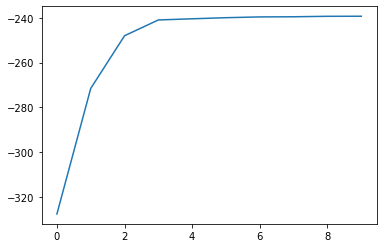

In [49]:
np.random.seed(0)
optim_reinforce = Optimizer(tree_log_probs,deepcopy(theta))

optim_reinforce.optimize_q_reinforce(10,100,
                                     alphas=[0.1,0.1],pop_size=pop_size)

print("final theta:",optim_reinforce.theta)
plt.plot(optim_reinforce.ELBO_ests)

iteration:  0
runtime: 0 mins
grad_norm estimate:  11.342377998233976
ELBO estimate:  -332.3766332667893

iteration:  10
runtime: 0 mins
grad_norm estimate:  10.726446341456125
ELBO estimate:  -322.9304045732631

iteration:  20
runtime: 0 mins
grad_norm estimate:  39.44012295510957
ELBO estimate:  -312.3872438194656

iteration:  30
runtime: 0 mins
grad_norm estimate:  278.47511963315293
ELBO estimate:  -316.6029617155378

iteration:  40
runtime: 0 mins
grad_norm estimate:  50.634490018439806
ELBO estimate:  -305.88626350641397

iteration:  50
runtime: 0 mins
grad_norm estimate:  11.326809636768601
ELBO estimate:  -303.04230069542945

iteration:  60
runtime: 0 mins
grad_norm estimate:  32.779144968894755
ELBO estimate:  -297.88720408047624

iteration:  70
runtime: 0 mins
grad_norm estimate:  4.068842431786902
ELBO estimate:  -302.0487173208153

iteration:  80
runtime: 0 mins
grad_norm estimate:  47.94518697355269
ELBO estimate:  -297.4632075946753

iteration:  90
runtime: 0 mins
grad_no

iteration:  760
runtime: 0 mins
grad_norm estimate:  1.423717736810728
ELBO estimate:  -258.2192881704738

iteration:  770
runtime: 0 mins
grad_norm estimate:  0.3673618096185429
ELBO estimate:  -259.31499917871724

iteration:  780
runtime: 0 mins
grad_norm estimate:  0.4895240532019989
ELBO estimate:  -258.71032984118744

iteration:  790
runtime: 0 mins
grad_norm estimate:  2.4287955995685575
ELBO estimate:  -258.2463935303542

iteration:  800
runtime: 0 mins
grad_norm estimate:  4.145971040176021
ELBO estimate:  -257.6348770968632

iteration:  810
runtime: 0 mins
grad_norm estimate:  0.18842688357784304
ELBO estimate:  -260.2507381522894

iteration:  820
runtime: 0 mins
grad_norm estimate:  0.9294747009639215
ELBO estimate:  -258.54647989815913

iteration:  830
runtime: 0 mins
grad_norm estimate:  1.2557514152844085
ELBO estimate:  -258.89269973240306

iteration:  840
runtime: 0 mins
grad_norm estimate:  0.6407080863049915
ELBO estimate:  -257.66220730806936

iteration:  850
runtime:

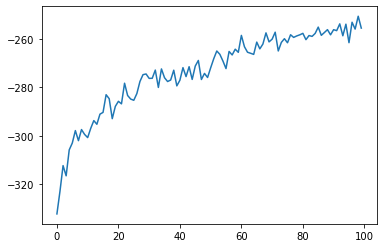

In [108]:
theta = np.zeros((2,n_species,n_species))
np.random.seed(0)
optim_VIMCO = Optimizer(tree_log_probs,deepcopy(theta))

optim_VIMCO.optimize_q_VIMCO(10,1000,
                             alphas=[0.01,0.01],
                             pop_size=pop_size)

print("final theta:",optim_VIMCO.theta)
plt.plot(optim_VIMCO.ELBO_ests)

In [76]:
theta0

array([[[0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e-09, 0.e+00]],

       [[0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00]]])

# test gradient of tree.logq

In [94]:
np.random.seed(0)
Z = np.random.normal(np.ones_like(theta[0]))
log_times = np.exp(theta[1])*Z+theta[0]
log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

def log_q_sample(theta):
    tree = Tree(theta,log_times,
                deepcopy(tree_log_probs),
                pop_size=pop_size)
    return tree.log_q

analytic_gradient = grad(log_q_sample)(theta)

# get numerical gradient
h = 0.000000001
tree1 = Tree(theta,
             log_times,
             deepcopy(tree_log_probs),
             pop_size=pop_size)
f1 = tree1.log_q

theta0 = deepcopy(theta)
theta0[0,1,0] += h

tree2 = Tree(theta0,
             log_times,
             deepcopy(tree_log_probs),
             pop_size=pop_size)

f2 = tree2.log_q

print(f2)
print(f1)
print(analytic_gradient)
print((f2-f1)/h)

-9.870816194484473
-9.87081619662406
[[[ 0.          0.          0.        ]
  [ 2.13958549  0.          0.        ]
  [ 2.13958549  0.84864279  0.        ]]

 [[ 0.          0.          0.        ]
  [ 3.67238088  0.          0.        ]
  [ 3.67238088 -0.27980541  0.        ]]]
2.139588062277653


In [103]:
def update_q(theta,ancestors):

    t = ancestors[0].parent.coal_time
    log_t = np.log(t)

    log_cum_sfs = 0
    log_pdfs_over_sfs = []

    log_cum_sfs_prior = 0
    log_pdfs_over_sfs_prior = []

    for leaf_a in ancestors[0].leaves:
        for leaf_b in ancestors[1].leaves:

            leaf_i = max(leaf_a,leaf_b)
            leaf_j = min(leaf_a,leaf_b)

            print(leaf_i)
            print(leaf_j)
            
            # update q
            mu = theta[0,leaf_i,leaf_j]
            log_sig = theta[1,leaf_i,leaf_j]
            sig = np.exp(log_sig)

            log_sf = np.log(0.5 - 0.5*erf((log_t-mu)/(np.sqrt(2)*sig)))
            log_pdf = -log_sig-0.5*np.log(2*np.pi)-log_t
            log_pdf = log_pdf - (((log_t-mu)/sig)**2)/2

            log_cum_sfs = log_cum_sfs + log_sf
            log_pdfs_over_sfs.append(log_pdf - log_sf)

    return log_cum_sfs + logsumexp(np.array(log_pdfs_over_sfs))

In [104]:
np.random.seed(0)
Z = np.random.normal(np.ones_like(theta[0]))
log_times = np.exp(theta[1])*Z+theta[0]
log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

def log_q_sample(theta):
    tree = Tree(theta,
                log_times,
                deepcopy(tree_log_probs),
                 pop_size=pop_size)
    return update_q(theta,tree.leaves[1:])

analytic_gradient = grad(log_q_sample)(theta)

# get numerical gradient
h = 0.000000001
theta1 = deepcopy(theta)
tree1 = Tree(theta1,
             log_times,
             deepcopy(tree_log_probs),
             pop_size=pop_size)

f1 = update_q(theta1,tree1.leaves[1:])

theta2 = deepcopy(theta)
theta2[0,2,1] += h

tree2 = Tree(theta2,
             log_times,
             deepcopy(tree_log_probs),
             pop_size=pop_size)

f2 = update_q(theta2,tree2.leaves[1:])

print(f2)
print(f1)
print(analytic_gradient)
print((f2-f1)/h)

2
1
2
1
2
1
-2.1276786180124705
-2.127678618861113
[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.84864279  0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.         -0.27980541  0.        ]]]
0.8486424896148037


In [ ]:
print(optim_reparam.ELBO_ests[-1])
print(optim_reinforce.ELBO_ests[-1])
print(optim_VIMCO.ELBO_ests[-1])

# Print out a random tree

In [ ]:
def write_newick(node):
    
    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time)
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time - node.coal_time
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)

    
for _ in range(10):
    Z = np.random.normal(np.ones_like(theta[0]))
    log_times = np.exp(theta[1])*Z+theta[0]
    log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)
    fig.show()

# Estimate the marginal likelihood

In [ ]:
optim = optim_reinforce
theta = optim.theta

In [ ]:
tree = Tree(optim.theta,log_times,
            deepcopy(tree_log_probs),
            pop_size=pop_size)

In [ ]:
n_exp = 100
n_samples = 100

priors = np.zeros(n_exp)
LL = np.zeros(n_exp)
MLL_all = np.zeros(n_exp)
ELBO_all = np.zeros(n_exp) 

for i in range(n_exp):

    MLL = np.zeros(n_samples)
    ELBO = np.zeros(n_samples)
    
    Zs = np.random.normal(size=(n_samples,n_species,n_species))

    for j,Z in enumerate(Zs):
        log_times = np.exp(theta[1])*Z+theta[0]
        log_times = log_times + np.triu(np.full(n_species, np.inf))
        tree = Tree(optim.theta,log_times,
                    deepcopy(tree_log_probs),
                    pop_size=pop_size)
        
        MLL[j] = tree.log_p - tree.log_q
        ELBO[j] = tree.log_p - tree.log_q
    
    priors[i] = tree.log_prior
    LL[i] = tree.log_like
    MLL_all[i] = logsumexp(MLL) - np.log(n_samples)
    ELBO_all[i] = np.mean(ELBO)

In [ ]:
plt.hist(priors,bins = 100)
plt.show()

In [ ]:
plt.hist(ELBO_all,bins = 100)
plt.show()

In [ ]:
plt.hist(MLL_all,bins = 100)
plt.show()

In [ ]:
plt.hist(LL,bins = 100)
plt.show()

In [ ]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

In [ ]:
log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()

# Plot the likelihood surface for 3-taxa trees

In [ ]:
def plot_q(theta,res):
    # select t lims from sampling 1000 trees
    min_time = np.min((-5*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
    max_time = np.max(( 3*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
    tlims = [min_time,max_time]

    #print(theta)
    log_p = np.zeros((3,res,res))
    log_q = np.zeros((3,res,res))
    ELBO = np.zeros((3,res,res))

    orders = [[0,1,2],[0,2,1],[1,2,0]]
    tau_labels = ['(({A},{B}),({A,B},{C}))',
                  '(({A},{C}),({A,C},{B}))',
                  '(({B},{C}),({A},{B,C})']

    for k,inds in enumerate(orders):

        time1s = np.linspace(tlims[0],tlims[1],res)
        time2s = np.linspace(tlims[0],tlims[1],res)

        for i,time1 in enumerate(time1s):
            for j,time2 in enumerate(time2s):

                if time1 > time2:
                    log_p[k,j,i] = -np.inf
                    log_q[k,j,i] = -np.inf

                else:
                    times = np.inf*np.ones((3,3))

                    inds1 = [inds[x] for x in [0,1]]
                    inds2 = [inds[x] for x in [0,2]]
                    inds3 = [inds[x] for x in [1,2]]

                    times[max(inds1),min(inds1)] = time1
                    times[max(inds2),min(inds2)] = time2
                    times[max(inds3),min(inds3)] = time2+1

                    tree = Tree(theta,times,tree_log_probs,
                                pop_size=pop_size)

                    log_p[k,j,i] = tree.log_p
                    log_q[k,j,i] = tree.log_q
                    ELBO[k,j,i] = np.exp(tree.log_q)*(tree.log_p - tree.log_q)
    log_p = log_p-logsumexp(log_p[~np.isnan(log_p)])+logsumexp(log_q[~np.isnan(log_q)])
    vmax = np.nanmax([log_p,log_q])

    i = 0
    plt.subplots(figsize = (20,12))
    for k in range(3):

        i += 1
        plt.subplot(3,3,i)

        plt.imshow(log_p[k], interpolation='nearest', origin='lower',
                   extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmax-6,vmax=vmax)
        plt.xlabel(r'$\log(t_1)$',fontsize = 16)
        plt.ylabel(r'$\log(t_2)$',fontsize = 16)
        plt.title(r'log(p), $\tau$ = %s' % tau_labels[k],fontsize = 16)
        plt.colorbar()

        plt.subplot(3,3,i+3)

        plt.imshow(log_q[k], interpolation='nearest', origin='lower',
                   extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmax-6,vmax=vmax)
        plt.xlabel(r'$\log(t_1)$',fontsize = 16)
        plt.ylabel(r'$\log(t_2)$',fontsize = 16)
        plt.title(r'log(q), $\tau$ = %s' % tau_labels[k],fontsize = 16)
        plt.colorbar()

    plt.show()
    return

In [ ]:
print("REINFORCE:")
plot_q(optim_reinforce.theta,res=50)
print("VIMCO:")
plot_q(optim_VIMCO.theta,res=50)
print("Reparam:")
plot_q(optim_reparam.theta,res=50)

# Visualize the boundary

In [ ]:
theta = optim.theta
res = 500

# select t lims from sampling 1000 trees
Z1 = 0
min_time = np.min((-5*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
max_time = np.max(( 3*np.exp(theta[1])+theta[0])[np.tril(np.full((n_species), True),k=-1)])
tlims = [min_time,max_time]

#print(theta)
log_p = np.zeros((3,res))
log_q = np.zeros((3,res))
ELBO = np.zeros((3,res))

eps = 0.00001

orders = [[0,1,2],[0,2,1],[1,2,0]]
tau_labels = ['(({A},{B}),({A,B},{C}))',
              '(({A},{C}),({A,C},{B}))',
              '(({B},{C}),({A},{B,C})']

for k,inds in enumerate(orders):
    
    time1s = np.linspace(tlims[0],tlims[1],res)
    
    for i,time1 in enumerate(time1s):
        
        time2 = time1 + eps
                
        times = np.inf*np.ones((3,3))

        inds1 = [inds[x] for x in [0,1]]
        inds2 = [inds[x] for x in [0,2]]
        inds3 = [inds[x] for x in [1,2]]

        times[max(inds1),min(inds1)] = time1
        times[max(inds2),min(inds2)] = time2
        times[max(inds3),min(inds3)] = time2+1

        tree = Tree(theta,times,tree_log_probs,
                    pop_size=pop_size)

        log_p[k,i] = tree.log_p
        log_q[k,i] = tree.log_q
        ELBO[k,i] = np.exp(tree.log_q)*(tree.log_p - tree.log_q)

In [ ]:
np.max(np.exp(log_q.T))

In [ ]:
plt.plot(time1s,np.exp(log_q.T)*(log_p.T-log_q.T))
plt.show()

In [ ]:
plt.plot(time1s,log_q.T,'-.')
plt.show()

In [ ]:
theta = optim.theta
res = 200

# select t lims from sampling 1000 trees
Z1 = -3
Z2s = np.linspace(-5,5,res)
Z3s = np.linspace(-5,5,res)
tlims = [-5,5]

#print(theta)
log_p = np.zeros((res,res))
log_q = np.zeros((res,res))
ELBO = np.zeros((res,res))
    
for i,Z2 in enumerate(Z2s):
    for j,Z3 in enumerate(Z3s):

        Z = np.array([[np.inf,np.inf,np.inf],
                      [Z2    ,np.inf,np.inf],
                      [Z3    ,Z1   ,np.inf]])

        log_times = np.exp(theta[1])*Z+theta[0]

        tree = Tree(theta,log_times,tree_log_probs,
                    pop_size=pop_size)

        log_p[j,i] = tree.log_p
        log_q[j,i] = tree.log_q
        ELBO[j,i] = (tree.log_p-tree.log_q)


In [ ]:
#log_p = log_p-logsumexp(log_p[~np.isnan(log_p)])+logsumexp(log_q[~np.isnan(log_q)])
vmaxp = np.nanmax([log_p])
vmaxq = np.nanmax([log_q])
plt.subplots(figsize = (20,12))
    
plt.subplot(1,3,1)

plt.imshow(log_p, interpolation='nearest', origin='lower',
           extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmaxp-6,vmax=vmaxp)
plt.xlabel(r'$Z_{ac}$',fontsize = 16)
plt.ylabel(r'$Z_{bc}$',fontsize = 16)
plt.title(r'log(p), $\tau$ = %s' % tau_labels[k],fontsize = 16)
plt.colorbar()

plt.subplot(1,3,2)

plt.imshow(log_q, interpolation='nearest', origin='lower',
           extent=[tlims[0],tlims[1],tlims[0],tlims[1]],vmin=vmaxq-6,vmax=vmaxq)
plt.xlabel(r'$Z_{ac}$',fontsize = 16)
plt.ylabel(r'$Z_{bc}$',fontsize = 16)
plt.title(r'log(q), $\tau$ = %s' % tau_labels[k],fontsize = 16)
plt.colorbar()
    
plt.subplot(1,3,3)

plt.imshow(ELBO, interpolation='nearest', origin='lower',
           extent=[tlims[0],tlims[1],tlims[0],tlims[1]])
plt.xlabel(r'$Z_{ac}$',fontsize = 16)
plt.ylabel(r'$Z_{bc}$',fontsize = 16)
plt.title(r'ELBO, $\tau$ = %s' % tau_labels[k],fontsize = 16)
plt.colorbar()
    
plt.show()

In [ ]:
theta

# Evaluate gradient of the ELBO

In [ ]:
genomes

In [ ]:
optim.theta

In [ ]:
np.exp(-1.6)

In [ ]:
# select t lims from plus or minus three standard deviations
min_time = np.min((-5*np.exp(optim.theta[1])+optim.theta[0])[np.tril(np.full((n_species), True),k=-1)])
max_time = np.max(( 3*np.exp(optim.theta[1])+optim.theta[0])[np.tril(np.full((n_species), True),k=-1)])
tlims = [min_time,max_time]

def ELBO_no_reparam(theta,res_no_reparam):

    ELBO = 0
    orders = [[0,1,2],[0,2,1],[1,2,0]]

    for k,inds in enumerate(orders):

        time1s = np.linspace(tlims[0],tlims[1],res_no_reparam)
        time2s = np.linspace(tlims[0],tlims[1],res_no_reparam)

        for i,time1 in enumerate(time1s):
            for j,time2 in enumerate(time2s):

                if time1 < time2:
                    
                    times = np.inf*np.ones((3,3))

                    inds1 = [inds[x] for x in [0,1]]
                    inds2 = [inds[x] for x in [0,2]]
                    inds3 = [inds[x] for x in [1,2]]

                    times[max(inds1),min(inds1)] = time1
                    times[max(inds2),min(inds2)] = time2
                    times[max(inds3),min(inds3)] = time2+1
                    
                    tree = Tree(theta,times,tree_log_probs,
                                pop_size=pop_size)

                    ELBO_hat = np.exp(tree.log_q)*(tree.log_p - tree.log_q)
                    
                    if not np.isnan(ELBO_hat):
                        
                        if i == 0:
                            length = 0
                        else:
                            length = np.exp(time1s[i]) - np.exp(time1s[i-1])
                            
                        if j == 0:
                            width = 0
                        else:
                            width = np.exp(time2s[j]) - np.exp(time2s[j-1])
                        
                        ELBO_hat = ELBO_hat*length*width
                        ELBO = ELBO + ELBO_hat
                    
    return ELBO

In [ ]:
ELBO_no_reparam(optim.theta,500)

In [ ]:
ELBO_no_reparam(optim.theta,300)

In [ ]:
ELBO_no_reparam(optim.theta,200)

In [ ]:
ELBO_no_reparam(optim.theta,100)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,100))(optim.theta)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,200))(optim.theta)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,300))(optim.theta)

In [ ]:
grad(lambda theta: ELBO_no_reparam(theta,500))(optim.theta)

# Reparameterize and see if the LOTUS applies

In [ ]:
res_reparam = 50

min_Z = -3
max_Z = 3

def ELBO_reparam(theta):
    
    ELBO = 0
    
    Z1s = np.linspace(min_Z,max_Z,res_reparam)
    Z2s = np.linspace(min_Z,max_Z,res_reparam)
    Z3s = np.linspace(min_Z,max_Z,res_reparam)
    
    for i,Z1 in enumerate(Z1s):
        for j,Z2 in enumerate(Z2s):
            for k,Z3 in enumerate(Z3s):
        
                Z = np.array([[np.inf,np.inf,np.inf],
                              [Z1    ,np.inf,np.inf],
                              [Z2    ,Z3    ,np.inf]])

                log_times = np.exp(theta[1])*Z+theta[0]

                tree = Tree(theta,log_times,tree_log_probs,
                            pop_size=pop_size)

                density = np.product(norm.pdf([Z1,Z2,Z3]))*((max_Z-min_Z)/res_reparam)**3

                ELBO_hat = density*(tree.log_p - tree.log_q)
        
                if not np.isnan(ELBO_hat):
                    ELBO = ELBO + ELBO_hat
                    
    return ELBO

In [ ]:
ELBO_reparam(optim.theta)

In [ ]:
grad(ELBO_reparam)(optim.theta)

# See if we can replace integration with sampling

In [ ]:
n_samples = 10000

# sample trees
Z1s = np.random.normal(size=n_samples)
Z2s = np.random.normal(size=n_samples)
Z3s = np.random.normal(size=n_samples)

def ELBO_reparam_sample(theta):
    
    ELBO = 0
    
    for Z1,Z2,Z3 in zip(Z1s,Z2s,Z3s):
        
        Z = np.array([[np.inf,np.inf,np.inf],
                      [Z1    ,np.inf,np.inf],
                      [Z2    ,Z3    ,np.inf]])

        log_times = np.exp(theta[1])*Z+theta[0]

        tree = Tree(theta,log_times,tree_log_probs,
                    pop_size=pop_size)

        density = 1/n_samples

        ELBO_hat = density*(tree.log_p - tree.log_q)

        if not np.isnan(ELBO_hat):
            ELBO = ELBO + ELBO_hat
                    
    return ELBO

print(ELBO_reparam_sample(optim.theta))
print(grad(ELBO_reparam_sample)(optim.theta))

# See if the sum of the gradients is the gradient of the sum

In [ ]:
res_reparam = 25

min_Z = -3
max_Z = 3

grad_ELBO_reparam = np.zeros_like(optim.theta)

Z1s = np.linspace(min_Z,max_Z,res_reparam)
Z2s = np.linspace(min_Z,max_Z,res_reparam)
Z3s = np.linspace(min_Z,max_Z,res_reparam)

for i,Z1 in enumerate(Z1s):
    for j,Z2 in enumerate(Z2s):
        for k,Z3 in enumerate(Z3s):

            Z = np.array([[np.inf,np.inf,np.inf],
                          [Z1    ,np.inf,np.inf],
                          [Z2    ,Z3    ,np.inf]])
            
            def ELBO_reparam_local(theta0):
                log_times = np.exp(theta0[1])*Z+theta0[0]
                tree = Tree(theta0,log_times,tree_log_probs,
                            pop_size=pop_size)
                return tree.log_p - tree.log_q

            grad_ELBO_hat = grad(ELBO_reparam_local)(optim.theta)
            density = np.product(norm.pdf([Z1,Z2,Z3]))*((max_Z-min_Z)/res_reparam)**3

            grad_ELBO_hat = density*grad_ELBO_hat

            if not np.isnan(grad_ELBO_hat).all():
                grad_ELBO_reparam = grad_ELBO_reparam + grad_ELBO_hat

In [ ]:
print(grad_ELBO_reparam)

# Plot both ELBOs as theta[0,2,0] changes

In [ ]:
h = 0.5
np.linspace(optim.theta[0,2,0]-h,optim.theta[0,2,0]+h,2)

In [ ]:
h = 0.1
thetas = np.linspace(optim.theta[0,2,0]-h,optim.theta[0,2,0]+h,3)

grad_ELBOS_reparam = []
grad_ELBOS_no_reparam = []

ELBOS_reparam = []
ELBOS_no_reparam = []

for theta in thetas:
    print(theta)
    
    theta0 = deepcopy(optim.theta)
    theta0[0,2,0] = theta
    
    ELBOS_reparam.append(ELBO_reparam(theta0))
    print("ELBO reparam:",ELBOS_reparam[-1])
    
    ELBOS_no_reparam.append(ELBO_no_reparam(theta0,500))
    print("ELBO no reparam:",ELBOS_no_reparam[-1])
    
    #grad_ELBOS_reparam.append(grad(ELBO_reparam)(theta0))
    #print("grad ELBO reparam:",grad_ELBOS_reparam[-1])
    
    #grad_ELBOS_no_reparam.append(grad(ELBO_no_reparam)(theta0))
    #print("grad ELBO no reparam:",grad_ELBOS_no_reparam[-1])
    
    print("")

In [ ]:
plt.plot(thetas,ELBOS_reparam)
plt.show()
plt.plot(thetas,ELBOS_no_reparam)
plt.show()

plt.plot(thetas,[x[0,2,0] for x in grad_ELBOS_reparam])
plt.show()
plt.plot(thetas,[x[0,2,0] for x in grad_ELBOS_no_reparam])
plt.show()

In [ ]:
h = 0.5
thetas = np.linspace(optim.theta[0,1,0]-h,optim.theta[0,1,0]+h,5)

grad_ELBOS_reparam = []
grad_ELBOS_no_reparam = []

ELBOS_reparam = []
ELBOS_no_reparam = []

for theta in thetas:
    print(theta)
    
    theta0 = deepcopy(optim.theta)
    theta0[0,1,0] = theta
    
    ELBOS_reparam.append(ELBO_reparam(theta0))
    print("ELBO reparam:",ELBOS_reparam[-1])
    
    ELBOS_no_reparam.append(ELBO_no_reparam(theta0))
    print("ELBO no reparam:",ELBOS_no_reparam[-1])
    
    grad_ELBOS_reparam.append(grad(ELBO_reparam)(theta0))
    print("grad ELBO reparam:",grad_ELBOS_reparam[-1])
    
    grad_ELBOS_no_reparam.append(grad(ELBO_no_reparam)(theta0))
    print("grad ELBO no reparam:",grad_ELBOS_no_reparam[-1])
    
    print("")

In [ ]:
plt.plot(thetas,ELBOS_reparam)
plt.show()
plt.plot(thetas,ELBOS_no_reparam)
plt.show()

plt.plot(thetas,[x[0,1,0] for x in grad_ELBOS_reparam])
plt.show()
plt.plot(thetas,[x[0,1,0] for x in grad_ELBOS_no_reparam])
plt.show()

# Finally, see if we can move the sampling outside

In [ ]:
n_samples = 1000

# select t lims from sampling 1000 trees
min_Z = -3
max_Z = 3
    
grad_ELBO = np.zeros_like(optim.theta)

Z1s = np.random.normal(size=n_samples)
Z2s = np.random.normal(size=n_samples)
Z3s = np.random.normal(size=n_samples)

for Z1,Z2,Z3 in zip(Z1s,Z2s,Z3s):

    Z = np.array([[np.inf,np.inf,np.inf],
                  [Z1    ,np.inf,np.inf],
                  [Z2    ,Z3    ,np.inf]])

    def ELBO_reparam_sample_local(theta0):
        times = np.exp(theta0[1])*Z+theta0[0]
        tree = Tree(theta0,times,genomes,
                    pop_size=pop_size)
        return tree.log_p - tree.log_q

    grad_ELBO_hat = grad(ELBO_reparam_local)(optim.theta)
    density = 1/n_samples

    grad_ELBO_hat = density*grad_ELBO_hat

    if not np.isnan(grad_ELBO_hat).all():
        grad_ELBO = grad_ELBO + grad_ELBO_hat
                
print(grad_ELBO)

# See if we are actually sampling from Q when we do this

In [ ]:
plt.hist([x[1,1,0] for x in grad_thetas])

In [ ]:
theta

In [ ]:
times

In [ ]:
t1s = []
t2s = []

for _ in range(10000):
    
    # draw times
    Z = np.random.normal(np.ones_like(optim.theta[0]))
    times = np.exp(optim.theta[1])*Z+optim.theta[0]
    maxi = np.max(times)
    times = times + np.triu(np.ones_like(optim.theta[0])*maxi)
    
    # find t1 and t2
    t1 = np.min(times)
    t2 = np.min(times[times != t1])
    
    t1s.append(t1)
    t2s.append(t2)
    
    last_coal = {0,1,2}
    last_coal.remove(np.nonzero(times == t1)[0][0])
    last_coal.remove(np.nonzero(times == t1)[1][0])

In [ ]:
plt.hist(t2s,bins = 100)